# Description
Trains and evaluates DistilBert token classification model with variant-only Wikipedia Homograph data only; one model for all labels.

### Imports

In [1]:
import os
import sys
import logging
from pathlib import Path
import re
from glob import glob
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple, TextIO
from transformers import RobertaForTokenClassification
from transformers import RobertaTokenizerFast, EvalPrediction
from transformers import Trainer, TrainingArguments
from transformers import AdamW
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
#from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score
#from pytorch_lightning.metrics.functional.classification import accuracy

### Variables

In [2]:
#Paths 
WHD_BERT_DATA = "C:/Users/jseal/Dev/dissertation/Data/WHD_RoBERTa/variant_stratified/"
WHD = 'C:/Users/jseal/Dev/dissertation/Data/WikipediaHomographData/data/'

#Txt splits
TRAIN_TXT = WHD_BERT_DATA + "train.txt"
DEV_TXT = WHD_BERT_DATA + "dev.txt"
TEST_TXT = WHD_BERT_DATA + "test.txt"

#Logging path
LOGS = './whd-variant-stratified-roberta-model_logs'

#Labels file
LABELS = WHD_BERT_DATA + "labels.txt"

#Homographs
#whd_df = pd.read_csv(WHD + 'WikipediaHomographData.csv')
#homographs = whd_df.drop_duplicates(subset='homograph')['homograph'].tolist()

# Model Variables
MAX_LENGTH = 128 #@param {type: "integer"}
BATCH_SIZE = 16 #@param {type: "integer"}
NUM_EPOCHS = 3 #@param {type: "integer"}
SAVE_STEPS = 100 #@param {type: "integer"}
LOGGING_STEPS = 100 #@param {type: "integer"}
SEED_1 = 15
SEED = 42 #@param {type: "integer"}
SEED_2 = 30
SEED_3 = 1234
SEED_4 = 500
STEPS = "steps"
EVAL_STEPS = 100
WARMUP_STEPS = 500
WEIGHT_DECAY = 0.01

MODEL_NAME = "roberta-base"
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

logger = logging.getLogger(__name__)

cuda:0


### Functions & classes

In [3]:
def read_set(file_path):
    file_path = Path(file_path)

    raw_text = file_path.read_text(encoding="utf8").strip()
    raw_docs = re.split(r'\n\t?\n', raw_text)
    token_docs = []
    tag_docs = []
    for doc in raw_docs:
        tokens = []
        tags = []
        for line in doc.split('\n'):
            token, tag = line.split('\t')
            if token.isalpha() or "'" in token:
                if token.startswith("'"):
                    continue
                if token.endswith("'"):
                    tokens.append(token)
                    tags.append(tag)
                elif "'" in token: 
                    if token == "n't": 
                        token = "not"
                        tokens.append(token)
                        tags.append(tag)
                    elif token.index("'") < len(token)/2:
                        token = token[token.index("'")+1:]
                        tokens.append(token)
                        tags.append(tag)
                else: 
                    tokens.append(token)
                    tags.append(tag)
        if len(tokens) > 2: 
            token_docs.append(tokens)
            tag_docs.append(tags)
        else: 
            continue

    return token_docs, tag_docs

def encode_tags(tags, encodings):
    labels = [[tag2id[tag] for tag in doc] for doc in tags]
    encoded_labels = [] 
    for doc_labels, doc_offset, e in zip(labels, encodings.offset_mapping, encodings.encodings):
        #Take only first split of split tokens 
        doc_offset_new = [v[1] for i, v in enumerate(zip(e.tokens, doc_offset)) if v[0].startswith("Ġ")]
        if len(doc_offset_new) != len(doc_offset): 
            padding = len(doc_offset) - len(doc_offset_new)
            for i in range(padding): 
                doc_offset_new.insert(-1, (0,0))
      
        # create an empty array of -100
        doc_enc_labels = np.ones(len(doc_offset_new),dtype=int) * -100
        arr_offset = np.array(doc_offset_new)   
      
        doc_enc_labels[(arr_offset[:,0] == 1)] = doc_labels
        encoded_labels.append(doc_enc_labels.tolist())
    
    return encoded_labels
        
class WHDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        self.tokenizer = tokenizer
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
def align_predictions(predictions: np.ndarray, 
                      label_ids: np.ndarray) -> Tuple[List[int], List[int], List[str]]:
    preds = np.argmax(predictions, axis=2)

    batch_size, seq_len = preds.shape

    out_label_list = [[] for _ in range(batch_size)]
    preds_list = [[] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(seq_len):
            if label_ids[i, j] != nn.CrossEntropyLoss().ignore_index:
                out_label_list[i].append(id2tag[label_ids[i][j]])
                preds_list[i].append(id2tag[preds[i][j]])
    return preds_list, out_label_list

def homograph_check(preds_list, out_label_list):
    '''Check that predictions to be evaluated are homographs, 
    not tokens from the sentence provided as context.'''
    pred_labels = zip(preds_list, out_label_list)
    unique_tags = [label.strip("\n") for label in open(LABELS).readlines()]
    preds = []
    labels = []
    for e in pred_labels:
        pred_label_pair = zip(e[0], e[1])
        for pred, label in pred_label_pair:
            if label is not 'O':
                preds.append(pred)
                labels.append(label)
    return labels, preds
    
def compute_metrics(p: EvalPrediction) -> Dict:
    '''Only compute metrics on homograph pronunciation predictions'''
    preds_list, labels_list = align_predictions(p.predictions, p.label_ids)
    targets, preds = homograph_check(preds_list, labels_list)

    return {
        "accuracy_score": accuracy_score(targets, preds),
        "balanced_accuracy_score": balanced_accuracy_score(targets, preds),
    }

def write_predictions_to_file(writer: TextIO, test_input_reader: TextIO, preds_list: List):
    example_id = 0
    for line in test_input_reader:
        if line.startswith("-DOCSTART-") or line == "" or line == "\n":
            writer.write(line)
            if not preds_list[example_id]:
                example_id += 1
        elif preds_list[example_id]:
            output_line = line.split()[0] + " " + preds_list[example_id].pop(0) + "\n"
            writer.write(output_line)
        else:
            logger.warning("Maximum sequence length exceeded: No prediction for '%s'.", line.split()[0])

# Script

In [4]:
#Get unique labels, enumeration/IDs, and make mappings
unique_tags = [label.strip("\n") for label in open(LABELS).readlines()]
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

In [5]:
#Make separate lists of aligned texts and tags
train_texts, train_tags = read_set(TRAIN_TXT)
dev_texts, dev_tags = read_set(DEV_TXT)
test_texts, test_tags = read_set(TEST_TXT)

In [6]:
#Make encodings for text 
tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME,add_prefix_space=True)
train_encodings = tokenizer(train_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)
dev_encodings = tokenizer(dev_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)

In [7]:
#Make encodings for labels
train_labels = encode_tags(train_tags, train_encodings)
dev_labels = encode_tags(dev_tags, dev_encodings)

In [8]:
#Make datasets
train_encodings.pop("offset_mapping") # don't want to pass this to the model
dev_encodings.pop("offset_mapping")
train_dataset = WHDataset(train_encodings, train_labels)
dev_dataset = WHDataset(dev_encodings, dev_labels)
#print(dev_dataset[0])

In [9]:
#Instantiate model, training args and trainer; train and evaluate
model = RobertaForTokenClassification.from_pretrained(MODEL_NAME,
                                                   num_labels=len(unique_tags))
model.to(device)

training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir='./whd-variant-stratified-roberta-model',    # output directory
    num_train_epochs=NUM_EPOCHS,              # total # of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=WARMUP_STEPS,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,                # strength of weight decay
    logging_dir=LOGS,                         # directory for storing logs
    evaluation_strategy=STEPS,
    eval_steps=EVAL_STEPS,
    seed=SEED_1,
    overwrite_output_dir=True,
)

trainer = Trainer(
    model=model,                         # instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

Step,Training Loss,Validation Loss,Accuracy Score,Balanced Accuracy Score
100,No log,0.617745,0.000000,0.000000
200,No log,0.601279,0.000000,0.000000
300,No log,0.548951,0.000000,0.000000
400,No log,0.475061,0.000000,0.000000
500,1.059132,0.393167,0.013453,0.008239
600,1.059132,0.293789,0.226457,0.135363
700,1.059132,0.211612,0.499253,0.307669
800,1.059132,0.157256,0.592676,0.373243
900,1.059132,0.138056,0.651719,0.411198
1000,0.240568,0.113075,0.625561,0.393059


C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814

C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


{'eval_loss': 0.06623896211385727,
 'eval_accuracy_score': 0.749626307922272,
 'eval_balanced_accuracy_score': 0.5130137874278499,
 'epoch': 3.0}

In [15]:
from statistics import mean 
predictions, label_ids, metrics = trainer.predict(dev_dataset)
preds_list, targets_list = align_predictions(predictions, label_ids)
targets_list, preds_list = homograph_check(preds_list, targets_list)

output_results_file = os.path.join(training_args.output_dir, "results.txt")
# if trainer.is_world_master():
#     with open(output_results_file, "w", encoding="utf8") as writer:
#         for key, value in metrics.items():
#             logger.info("  %s = %s", key, value)
#             writer.write("%s = %s\n" % (key, value))

# Save predictions
#output_predictions_file = os.path.join(training_args.output_dir, "predictions.txt")
to_df = zip(preds_list, targets_list)
print('Micro Accuracy')
df = pd.DataFrame(to_df, columns=['Preds', 'Targets'])
df_correct = df[df['Preds'] == df['Targets']]
print(len(df_correct)/len(df))
print('Macro Accuracy')
group_accuracies_for_mean = []
group_accuracies = []
for idx, group in df.groupby('Targets'):
    grp = {}
    grp["wordid"] = idx
    print(idx)
    correct = group[group['Preds'] == group['Targets']]
    accuracy = len(correct)/len(group)
    print(accuracy)
    grp["accuracy"] = accuracy
    group_accuracies.append(grp)
    group_accuracies_for_mean.append(accuracy)
print(mean(group_accuracies_for_mean))
accuracies_df = pd.DataFrame(group_accuracies)

C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Micro Accuracy
0.749626307922272
Macro Accuracy
abuse_nou
0.6666666666666666
abuse_vrb
0.0
abuses_nou
0.875
abuses_vrb
0.0
advocate_nou
1.0
advocate_vrb
0.0
affect
1.0
affect_nou-psy
0.0
affiliate_nou
1.0
affiliate_vrb
0.0
aged
0.7
aged_adj
0.0
aggregate_adj-nou
0.8888888888888888
aggregate_vrb
0.0
alternate_adj-nou
0.8
alternate_vrb
0.0
analyses_nou
0.8888888888888888
analyses_vrb
0.0
animate_adj-nou
0.25
animate_vrb
1.0
approximate_adj-nou
1.0
approximate_vrb
0.0
articulate_adj
1.0
articulate_vrb
0.8333333333333334
associate_adj-nou
1.0
associate_vrb
0.0
attribute_nou
0.8571428571428571
attribute_vrb
1.0
axes_nou
0.8
axes_nou-vrb
0.0
bass
1.0
bass_corp
0.0
blessed_adj
0.75
blessed_vrb
1.0
bow_nou-knot
0.25
bow_nou-ship
0.5
buffet_nou
1.0
buffet_vrb
0.0
celtic
1.0
celtic_adj-nou-sports
0.3333333333333333
close_adj-nou
0.9
close_vrb
0.0
combine_nou
0.0
combine_vrb
1.0
compound_nou
0.7272727272727273
compound_vrb
0.0
compress
1.0
compress_nou
0.0
conduct_nou
0.4
conduct_vrb
0.8
confines

In [16]:
output_predictions_file = os.path.join('./whd-variant-stratified-roberta-model', "predictions.txt")

In [17]:
output_predictions_file

'./whd-variant-stratified-roberta-model\\predictions.txt'

In [18]:
pd.set_option('display.max_rows', None)

In [19]:
accuracies_df.sort_values("accuracy")

,wordid,accuracy
57,conscript_vrb,0.000000
184,polish,0.000000
79,defect_vrb,0.000000
153,laminate_vrb,0.000000
123,impact_vrb,0.000000
74,correlate_nou,0.000000
191,present_vrb,0.000000
192,produce_nou,0.000000
71,convict_vrb,0.000000
195,progress_vrb,0.000000


In [20]:
hids = pd.read_csv("C:/Users/jseal/Dev/dissertation/Data_Exploration/WHD/hids.csv")

In [21]:
hids_acc = pd.merge(hids, accuracies_df, on='wordid')

In [22]:
hids_acc.sort_values(["accuracy"])

,Unnamed: 0,homograph,wordid,wordid_count,ttl,percent_ttl,accuracy
127,1,implement,implement_nou,9,90,0.100000,0.000000
90,0,discard,discard_nou,24,90,0.266667,0.000000
165,1,misuse,misuse_vrb,7,88,0.079545,0.000000
87,1,diagnoses,diagnoses_vrb,20,90,0.222222,0.000000
85,1,deliberate,deliberate_vrb,3,89,0.033708,0.000000
167,1,mobile,mobile_geo,4,89,0.044944,0.000000
83,1,delegate,delegate_vrb,8,90,0.088889,0.000000
81,1,degenerate,degenerate_vrb,15,90,0.166667,0.000000
171,1,ornament,ornament_vrb,4,90,0.044444,0.000000
79,1,defect,defect_vrb,11,90,0.122222,0.000000


In [23]:
hids_acc = hids_acc[hids_acc['accuracy'] < 1.0]

In [24]:
hids_acc_prevalence = hids_acc[["wordid", "percent_ttl"]]
hids_acc_acc = hids_acc[["wordid", "accuracy"]]

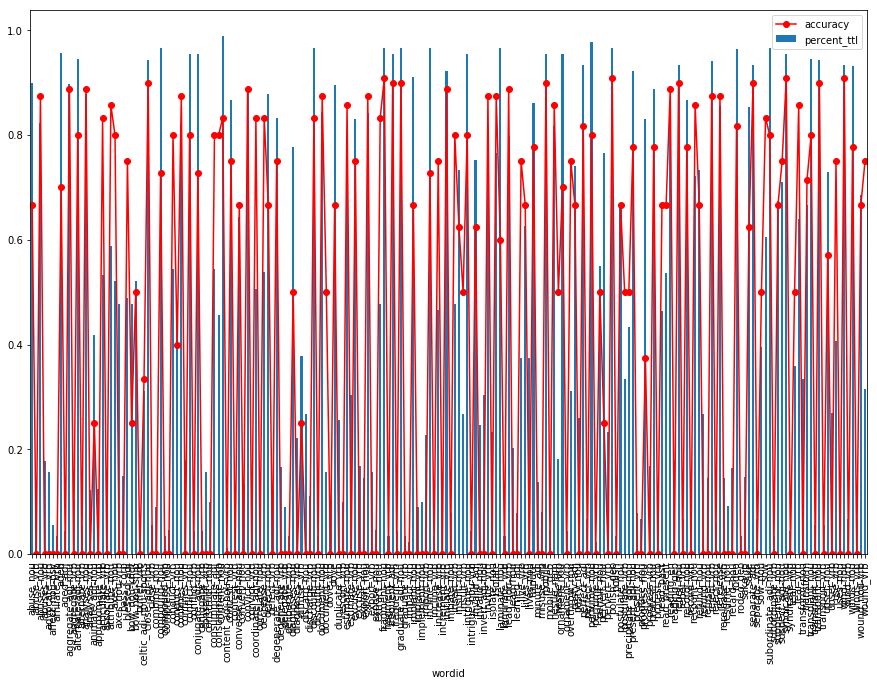

In [25]:
import matplotlib.pylab as plt
%matplotlib inline  

ax = hids_acc_acc.plot(
    x='wordid', linestyle='-', marker='o', color="red")
hids_acc_prevalence.plot(x='wordid', kind='bar', ax=ax, figsize=(15,10))

plt.show()

In [26]:
hids_acc = pd.merge(hids, accuracies_df, on='wordid')
homs = hids_acc[hids_acc["percent_ttl"] < 0.2]['homograph'].tolist()
homs

['abuse',
 'abuses',
 'advocate',
 'affect',
 'affiliate',
 'aged',
 'aggregate',
 'alternate',
 'analyses',
 'approximate',
 'associate',
 'bass',
 'buffet',
 'close',
 'combine',
 'compound',
 'compress',
 'confines',
 'conflict',
 'conjugate',
 'conscript',
 'construct',
 'content',
 'contest',
 'convert',
 'convict',
 'correlate',
 'defect',
 'degenerate',
 'delegate',
 'deliberate',
 'discharge',
 'discount',
 'document',
 'dove',
 'escort',
 'excuse',
 'exploit',
 'export',
 'expose',
 'fragment',
 'frequent',
 'graduate',
 'impact',
 'implant',
 'implement',
 'incline',
 'increment',
 'initiate',
 'intrigue',
 'laminate',
 'learned',
 'minute',
 'misuse',
 'mobile',
 'nestle',
 'ornament',
 'perfect',
 'perfume',
 'polish',
 'present',
 'produce',
 'progress',
 'protest',
 'reading',
 'rebel',
 'record',
 'refuse',
 'reject',
 'rerelease',
 'resume',
 'retard',
 'rodeo',
 'sake',
 'separate',
 'subordinate',
 'syndicate',
 'transplant',
 'transport',
 'uses',
 'wind',
 'winds']

In [27]:
len(homs)

82

In [28]:
hids_acc['homograph'].nunique()

128

# Train and eval together

In [29]:
hids = pd.read_csv("C:/Users/jseal/Dev/dissertation/Data_Exploration/WHD/train_eval_hids.csv")

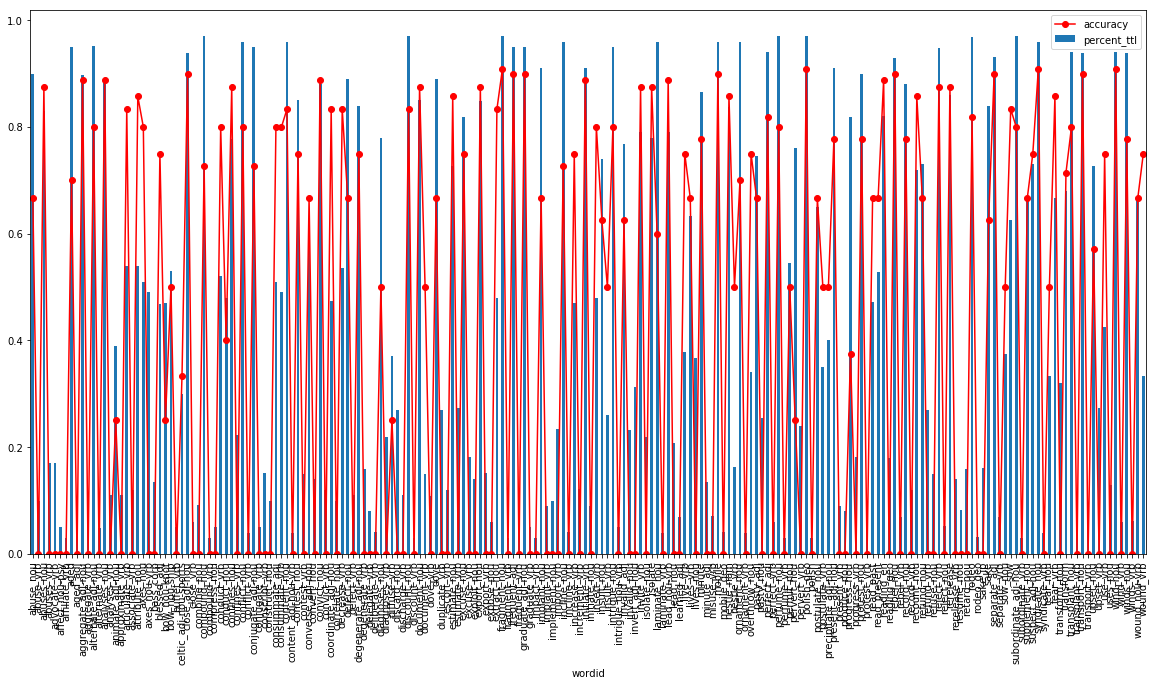

In [30]:
hids_acc = pd.merge(hids, accuracies_df, on='wordid')
hids_acc = hids_acc[hids_acc['accuracy'] < 1.0]
hids_acc_prevalence = hids_acc[["wordid", "percent_ttl"]]
hids_acc_acc = hids_acc[["wordid", "accuracy"]]
ax = hids_acc_acc.plot(
    x='wordid', linestyle='-', marker='o', color="red")
hids_acc_prevalence.plot(x='wordid', kind='bar', ax=ax, figsize=(20,10))

plt.show()

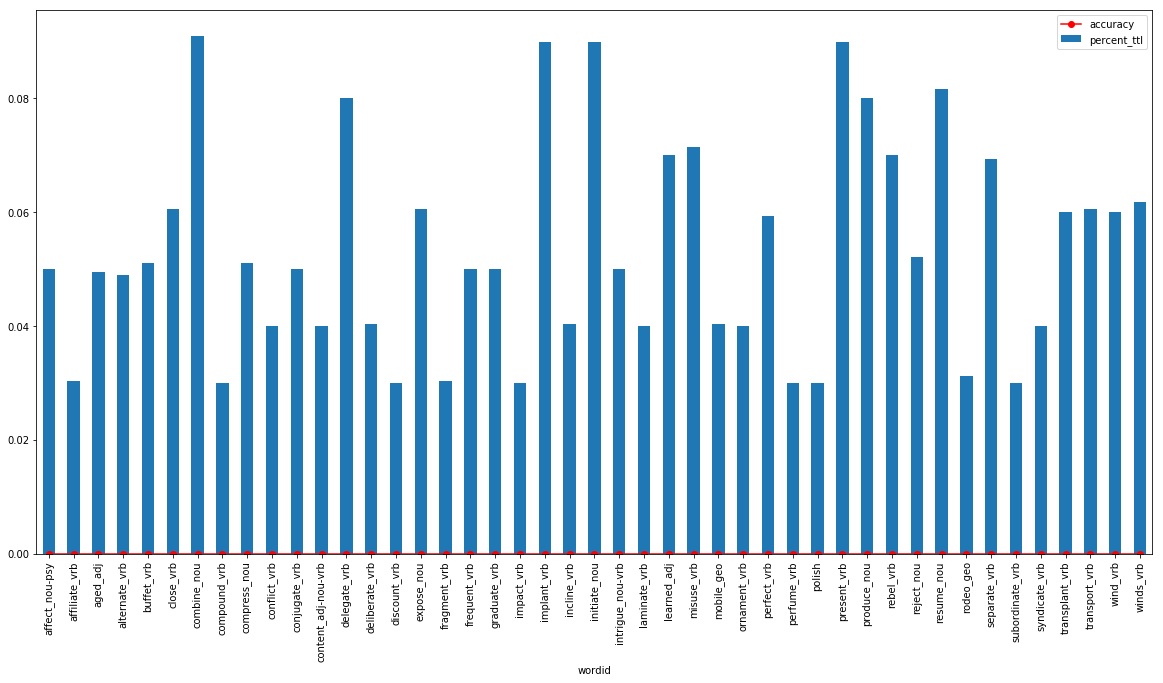

In [31]:
hids_acc = pd.merge(hids, accuracies_df, on='wordid')
hids_acc = hids_acc[hids_acc['percent_ttl'] < 0.1]
hids_acc_prevalence = hids_acc[["wordid", "percent_ttl"]]
hids_acc_acc = hids_acc[["wordid", "accuracy"]]
ax = hids_acc_acc.plot(
    x='wordid', linestyle='-', marker='o', color="red")
hids_acc_prevalence.plot(x='wordid', kind='bar', ax=ax, figsize=(20,10))

plt.show()

In [32]:
#WITH SEED_2
#Instantiate model, training args and trainer; train and evaluate
# config = DistilBertConfig.from_pretrained(MODEL_NAME, 
#                                           output_hidden_states=True, 
#                                           #idx2label=id2tag, 
#                                           num_labels=len(unique_tags))
# model = DistilBertForTokenClassification.from_pretrained(MODEL_NAME,config=config)
model = RobertaForTokenClassification.from_pretrained(MODEL_NAME,
                                                         num_labels=len(unique_tags))
model.to(device)

training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir='./whd-variant-stratified-roberta-model',    # output directory
    num_train_epochs=NUM_EPOCHS,              # total # of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=WARMUP_STEPS,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,                # strength of weight decay
    logging_dir=LOGS,                         # directory for storing logs
    evaluation_strategy=STEPS,
    eval_steps=EVAL_STEPS,
    seed=SEED_2,
    overwrite_output_dir=True,
)

trainer = Trainer(
    model=model,                         # instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

Step,Training Loss,Validation Loss,Accuracy Score,Balanced Accuracy Score
100,No log,0.617115,0.000000,0.000000
200,No log,0.596638,0.000000,0.000000
300,No log,0.560114,0.000000,0.000000
400,No log,0.491411,0.000000,0.000000
500,1.138388,0.437561,0.000000,0.000000
600,1.138388,0.384162,0.097907,0.058873
700,1.138388,0.276534,0.317638,0.196996
800,1.138388,0.189615,0.490284,0.304704
900,1.138388,0.150715,0.530643,0.334121
1000,0.290458,0.121410,0.620329,0.391510


C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814

C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


{'eval_loss': 0.06517841666936874,
 'eval_accuracy_score': 0.7294469357249627,
 'eval_balanced_accuracy_score': 0.48499123489357865,
 'epoch': 3.0}

In [33]:
#WITH SEED_3
#Instantiate model, training args and trainer; train and evaluate
# config = DistilBertConfig.from_pretrained(MODEL_NAME, 
#                                           output_hidden_states=True, 
#                                           #idx2label=id2tag, 
#                                           num_labels=len(unique_tags))
# model = DistilBertForTokenClassification.from_pretrained(MODEL_NAME,config=config)
model = RobertaForTokenClassification.from_pretrained(MODEL_NAME,
                                                         num_labels=len(unique_tags))
model.to(device)

training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir='./whd-variant-stratified-roberta-model',    # output directory
    num_train_epochs=NUM_EPOCHS,              # total # of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=WARMUP_STEPS,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,                # strength of weight decay
    logging_dir=LOGS,                         # directory for storing logs
    evaluation_strategy=STEPS,
    eval_steps=EVAL_STEPS,
    seed=SEED_3,
    overwrite_output_dir=True,
)

trainer = Trainer(
    model=model,                         # instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

Step,Training Loss,Validation Loss,Accuracy Score,Balanced Accuracy Score
100,No log,0.619552,0.000000,0.000000
200,No log,0.600719,0.000000,0.000000
300,No log,0.561926,0.000000,0.000000
400,No log,0.494167,0.000000,0.000000
500,1.013310,0.424205,0.007474,0.003862
600,1.013310,0.351281,0.172646,0.101613
700,1.013310,0.256592,0.322123,0.199831
800,1.013310,0.195122,0.476831,0.299933
900,1.013310,0.147751,0.568012,0.355490
1000,0.276928,0.122720,0.634529,0.395822


C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814

C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


{'eval_loss': 0.06500615179538727,
 'eval_accuracy_score': 0.7414050822122571,
 'eval_balanced_accuracy_score': 0.5047954432720058,
 'epoch': 3.0}

In [34]:
#WITH SEED_4
#Instantiate model, training args and trainer; train and evaluate
# config = DistilBertConfig.from_pretrained(MODEL_NAME, 
#                                           output_hidden_states=True, 
#                                           #idx2label=id2tag, 
#                                           num_labels=len(unique_tags))
# model = DistilBertForTokenClassification.from_pretrained(MODEL_NAME,config=config)
model = RobertaForTokenClassification.from_pretrained(MODEL_NAME,
                                                         num_labels=len(unique_tags))
model.to(device)

training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir='./whd-variant-stratified-roberta-model',    # output directory
    num_train_epochs=NUM_EPOCHS,              # total # of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=WARMUP_STEPS,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,                # strength of weight decay
    logging_dir=LOGS,                         # directory for storing logs
    evaluation_strategy=STEPS,
    eval_steps=EVAL_STEPS,
    seed=SEED_4,
    overwrite_output_dir=True,
)

trainer = Trainer(
    model=model,                         # instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

Step,Training Loss,Validation Loss,Accuracy Score,Balanced Accuracy Score
100,No log,0.626447,0.000000,0.000000
200,No log,0.600555,0.000000,0.000000
300,No log,0.544233,0.000000,0.000000
400,No log,0.475294,0.000000,0.000000
500,1.095074,0.381060,0.096413,0.058651
600,1.095074,0.259460,0.374439,0.227725
700,1.095074,0.202179,0.486547,0.300556
800,1.095074,0.149733,0.571749,0.359917
900,1.095074,0.124959,0.571749,0.360271
1000,0.232604,0.103418,0.656203,0.416995


C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814

C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


{'eval_loss': 0.062307439744472504,
 'eval_accuracy_score': 0.7428998505231689,
 'eval_balanced_accuracy_score': 0.5065315543831169,
 'epoch': 3.0}